(reversible-turbine-example)=
# Reversible turbines

This example is available in the following formats:

- pyshop
    - [](basic_pump.py)

## Introduction

This example imports a basic model and adds a reversible turbine modelled as two separate [generator](generator) and [pump](pump) objects. To ensure that the pump and generator does not operate at the same time, two [commit_groups](commit_group) are created to force the optimization to choose between production and pumping. This assumes that the reversible turbine is a single turbine-generator machine, and not a ternary set of one pump and one turbine that can run in hydraulic short circuit.

## Imports

In [1]:
#Necessary imports used in all examples
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

from pyshop import ShopSession

#Functions used in this example for building a basic SHOP model and running it
from basic_pump import build_model, run_model

## Create a SHOP session and import basic model from file function

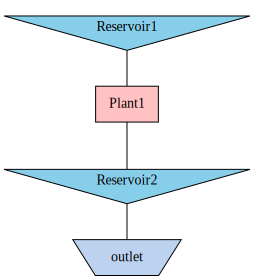

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a basic SHOP model
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

## Add a variable speed pump

Pumps can be added as pump objects, and need to be connected to a [plant](plant). We then apply attributes to the pump object. The pump added to model "half" of the reversible turbine is a variable speed pump, see [the binary pump example](binary-pump-example) for modelling of binary pumps. The difference between a binary and variable speed pump in SHOP is that multiple points are added in the [turbine efficiency curves](pump:turb_eff_curves) for variable speed pumps. The [p_min](pump:p_min) and [p_max](pump:p_max) attributes of the pump are set to limit the consumption to be between 30 and 50 MW.

The upper reservoir is also set to be full at the start of the optimization, and the generator is committed to be on in all  hours.

In [3]:
#Add variable speed pump
pump = shop.model.pump.add_object("P1P1")
pump.connect_to(shop.model.plant.Plant1)
pump.penstock.set(1)
pump.p_nom.set(50)
pump.p_min.set(30)
pump.p_max.set(50)
pump.startcost.set(500)
pump.gen_eff_curve.set(pd.Series([100,100], index=[0,50]))

c1 = pd.Series([84,86,85],index=[64,90,110],name=40)
c2 = pd.Series([82.5,84,83],index=[60,80,90],name=50)
c3 = pd.Series([79,82.5,82],index=[40,65,70],name=60)

pump.turb_eff_curves.set([c1,c2,c3])

#Set upper reservoir to almost full at the start
rsv1 = shop.model.reservoir["Reservoir1"]
rsv1.start_head.set(rsv1.hrl.get()-1)

#Force generator to run in all time steps
gen = shop.model.generator["P1G1"]
gen.committed_in.set(1)

When we plot the market price, we see that the first hours have a low price compared to the water value in the upper reservoir. This makes it economical to pump for the first hours, but this is not possible since the generator is committed to be on for the whole period.

In [4]:
# Plot market price and water value of reservoirs
spot_price=shop.model.market.Day_Ahead.sale_price.get()

fig = go.Figure()
colorscale = px.colors.sequential.RdBu_r
color = 1
fig.add_trace(go.Scatter(x=spot_price.index, marker_color = colorscale[color], y=spot_price.values, name="Market price"))

for rsv in shop.model.reservoir:
    color+=1
    end_water_value=rsv.energy_value_input.get()
    water_value=pd.Series([end_water_value]*len(spot_price),index=spot_price.index)
    curve_name="Water value of "+rsv.get_name()
    fig.add_trace(go.Scatter(x=water_value.index, y=water_value.values, marker_color = colorscale[color], name=curve_name, line=dict(dash="dot")))
    
fig.update_layout(title="<b>Market price and water value of reservoirs</b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Price</b> (€/MWh)")

fig.show()

## Run SHOP
We first run a naive optimization where the pump and generator are unaware that they are coupled and unable to operate at the same time.

In [5]:
run_model(shop)

We observe that the pump is used in the first six hours of the period, even though the generator is also producing power. This is not possible when dealing with a reversible turbine, but additional input is required for SHOP to recognize this.

In [6]:
# Plotting pump consumption and generator production
consumption=pump.consumption.get()
production=gen.production.get()
fig = go.Figure()
colorscale = px.colors.sequential.Magenta
fig.add_trace(go.Bar(x=consumption.index, y=consumption.values, name="Pump consumption", marker_color=colorscale[1]))
fig.add_trace(go.Bar(x=production.index, y=production.values, name="Generator production", marker_color=colorscale[6]))
fig.update_layout(title="<b>Pump consumption and generator production</b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Production/Consumption</b> (MW)")

## Using commit_group to stop simultaneous pumping and production

To stop the pump and generator running at the same time, we can use the [commit_group object](commit_group). A commit_group is simply a collection of generators and pumps. When two commit_groups are connected, the units connected to the first group can not run when any of the units in the other group is running, and vice versa. No other input is required for the commit_groups, only the connections.

First we recreate the previous model:

In [7]:
#Create a standard ShopSession
shop=ShopSession()
#Build a basic SHOP model
build_model(shop)

#Add variable speed pump
pump = shop.model.pump.add_object("P1P1")
pump.connect_to(shop.model.plant.Plant1)
pump.penstock.set(1)
pump.p_nom.set(50)
pump.p_min.set(30)
pump.p_max.set(50)
pump.startcost.set(500)
pump.gen_eff_curve.set(pd.Series([100,100], index=[0,50]))

c1 = pd.Series([84,86,85],index=[64,90,110],name=40)
c2 = pd.Series([82.5,84,83],index=[60,80,90],name=50)
c3 = pd.Series([79,82.5,82],index=[40,65,70],name=60)

pump.turb_eff_curves.set([c1,c2,c3])

#Set upper reservoir to almost full at the start
rsv1 = shop.model.reservoir["Reservoir1"]
rsv1.start_head.set(rsv1.hrl.get()-1)

#Force generator to run in all time steps
gen = shop.model.generator["P1G1"]
gen.committed_in.set(1)

Now we add two commit_groups and connect the pump to one group and the generator to the other group. The the two commit_groups are then connected, which means that the pump and generator cannot operate at the same time.

In [8]:
cg1 = shop.model.commit_group.add_object("cg1")
cg2 = shop.model.commit_group.add_object("cg2")

cg1.connect_to(pump)
cg2.connect_to(gen)

#Exclude pump in cg1 from running when generator in cg2 is on
cg1.connect_to(cg2)

Since the commit_group constraints are applied directly to the binary variables that decide whether a unit is on or off, it is important to use MIP to ensure the constraints are enforced.

In [9]:
shop.set_universal_mip("on",[])
run_model(shop)

The results below show that the pump no longer operates in the beginning of the optimization since the generator is forced to run.

In [10]:
# Plotting pump consumption and generator production
consumption=pump.consumption.get()
production=gen.production.get()
fig = go.Figure()
colorscale = px.colors.sequential.Magenta
fig.add_trace(go.Bar(x=consumption.index, y=consumption.values, name="Pump consumption", marker_color=colorscale[1]))
fig.add_trace(go.Bar(x=production.index, y=production.values, name="Generator production", marker_color=colorscale[6]))
fig.update_layout(title="<b>Pump consumption and generator production</b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Production/Consumption</b> (MW)")